## 1. Introduction & Problem Framing

### **What Is the Problem Being Solved?**

In the real world, perfect data is never guaranteed. Images could be blurry, noisy, off-center, or distorted in ways that models are unprepared for. We wanted to explore how a lightweight model handles the messy reality of the real world. To accomplish this, we started with the MNIST dataset as a controlled baseline for digit recognition. From that baseline, we introduced MNIST-C—a corrupted version of MNIST—plus a bonus set that introduced a combined total of thirty synthetic distortions. The model was never exposed to any of these during initial training, which gave us a clean benchmark for assessing generalization.
From there, we implemented a curriculum-based training pipeline, where the model gradually learned to handle increasing levels of corruption. This provided a structured way of improving generalization without overfitting any single corruption type. To test its ability to generalize across domains, we finally evaluated the trained model on EMNIST, a dataset with digits written in different handwriting styles.
This project is ultimately about building models that can handle imperfection, perform well under ideal conditions, and still hold up when the data gets messy.


## 2. Setup and Imports

In [1]:
# PYTORCH + TRAINING
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

# IMAGE PROCESSING + AUGMENTATION
import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as TF
import io  # For JPEG compression

# DATA HANDLING + ARRAYS
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
from scipy.ndimage import gaussian_filter, map_coordinates
import cv2

# FILE IO 
from pathlib import Path
import random
from collections import defaultdict

# EVALUATION
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# VISULIZATION AND Plotting
import seaborn as sns
import matplotlib.pyplot as plt


## 3. Dataset Preparation

### 3.1 Load and Wrap Clean MNIST Dataset

#### **Preprocessing and Dataset Handling**

We got this dataset from https://www.kaggle.com/datasets/sivasankaru/mnist-npy-file-dataset

Before training or evaluation, we applied a consistent set of preprocessing steps:

- All MNIST images were normalized and resized to 28×28 grayscale.  
- Data was loaded from `.npy` arrays and served as our clean, uncorrupted baseline.  
- Labels were left unchanged and matched directly to their digit class (0–9).  




In [2]:
class MNISTDataset(Dataset):
    def __init__(self, img_path, label_path, to_rgb=False, resize_to=None):
        self.images = np.load(img_path).astype(np.float32) / 255.0  # Fully loaded into RAM
        self.labels = np.load(label_path)
        self.to_rgb = to_rgb
        self.resize_to = resize_to

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  
        label = self.labels[idx]

        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)

        img_pil = TF.to_pil_image(img)

        if self.to_rgb:
            img_pil = img_pil.convert("RGB")

        if self.resize_to:
            img_pil = TF.resize(img_pil, self.resize_to)

        img_tensor = TF.to_tensor(img_pil)
        return img_tensor, int(label.item()) if isinstance(label, np.ndarray) else int(label)

In [3]:
MNIST_ROOT = "data/mnist"

# Load trainin and test for clean MNIST
train_mnist = MNISTDataset(
    "data/mnist/train_images.npy",
    "data/mnist/train_labels.npy",
    to_rgb=False
)

test_mnist = MNISTDataset(
    "data/mnist/test_images.npy",
    "data/mnist/test_labels.npy",
    to_rgb=False
)

### 3.2 Visualize Clean MNIST Samples

In [4]:
def get_mnist_examples_by_digit(dataset, digits=range(10)):
    seen = set()
    samples = []

    for x, y in dataset:
        if int(y) in digits and int(y) not in seen:
            seen.add(int(y))
            img = TF.to_pil_image(x)
            samples.append((img, y))
        if len(seen) == len(digits):
            break

    return samples

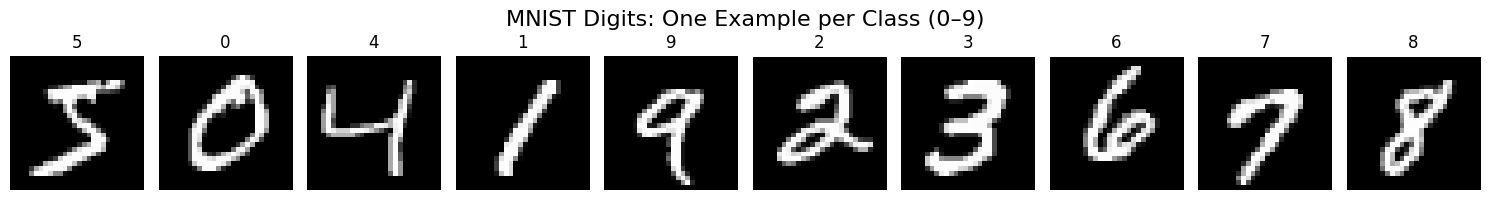

In [5]:
digit_samples = get_mnist_examples_by_digit(train_mnist)

plt.figure(figsize=(15, 2))
for i, (img, label) in enumerate(digit_samples):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")

plt.suptitle("MNIST Digits: One Example per Class (0–9)", fontsize=16)
plt.tight_layout()
plt.show()

## 4. Baseline Model and Training

### 4.1 Define Baseline CNN

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4)
        )

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        return self.fc2(x)

### 4.2 Training Utilities

In [7]:
# Choses Cuda if Avail 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Standard Training Loop 

# Runs a standard epoch based training, returns DF with train/ test accuracy per epoch
# Can Optionaly do per digit accuracy report on final epoch, confustion matric cisualtations, compatability with corruption eval  

def train_loop(
    model,
    train_loader,
    test_loader,
    optimizer,
    device,
    num_epochs=5,
    show_confusion=False,
    per_digit=False,
    corruption_dict=None
):
    history = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_model(model, train_loader, optimizer, device)

        model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = model(images)
                preds = outputs.argmax(dim=1).cpu()
                all_preds.extend(preds.tolist())
                all_labels.extend(labels.tolist())

        test_acc = accuracy_score(all_labels, all_preds)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "test_acc": test_acc
        })

        if epoch == num_epochs:
            if per_digit:
                print("\nPer-Digit Accuracy Report:")
                print(classification_report(all_labels, all_preds, digits=4))
            if show_confusion:
                cm = confusion_matrix(all_labels, all_preds)
                plt.figure(figsize=(8, 6))
                plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
                plt.title("Confusion Matrix")
                plt.colorbar()
                plt.xlabel("Predicted Label")
                plt.ylabel("True Label")
                plt.show()

    return pd.DataFrame(history)

In [9]:
# Trains Model on a Dataloader and returns average loss and accuracy ( single epoch )

def train_model(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluates model on test loader and ttrturns a Data frames 
# Shows per class breakdown and confusion matric
def evaluate_model(model, test_loader, device, show_confusion=False, per_digit=False, verbose=True):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    acc = float(accuracy_score(all_labels, all_preds))

    if verbose:
        print(f"\nTotal Accuracy: {acc:.4f}")

    if per_digit:
        print("\nPer-Digit Accuracy Report:")
        print(classification_report(all_labels, all_preds, digits=4))

    if show_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

    return pd.DataFrame([{
        "total_accuracy": acc,
        "num_samples": int(len(all_labels))
    }])

#Iterates over corruption datasets and evalues model on each
def evaluate_per_corruption(model, corruption_dict, device, batch_size=128):
    results = []

    for name, dataset in corruption_dict.items():
        loader = DataLoader(dataset, batch_size=batch_size)
        result_df = evaluate_model(model, loader, device, verbose=False)
        acc = float(result_df.loc[0, "total_accuracy"])  
        num_samples = int(result_df.loc[0, "num_samples"])

        results.append({
            "corruption": name,
            "accuracy": acc,
            "num_samples": num_samples
        })

    return pd.DataFrame(results).sort_values(by="accuracy", ascending=True).reset_index(drop=True)

### 4.3 Train the Baseline

#### **The Baseline and What It Tells Us**
To understand the value of our approach, we began by training a simple CNN on clean MNIST without any corruption, augmentation, or curriculum. The baseline model achieved ~99% accuracy on the clean MNIST test set.

#### **What We Analyzed**

- Measured clean accuracy as a ceiling for peformance.  
- Confirmed that even small CNNs can achieve near-perfect performance on pristine data.  
- Sanity check to validate model architecture and training pipeline.


In [10]:
# Sets Model
mnist_model = SimpleCNN().to(device)

# Wrap Datasets in DataLoaders 
train_loader = DataLoader(train_mnist, batch_size=128, shuffle=True)
test_loader = DataLoader(test_mnist, batch_size=128)

# Optimizer
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=0.001)

# === Train and Evaluate ===
minst_inital_df = train_loop(
    model=mnist_model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    show_confusion=False,
    per_digit=False,
    corruption_dict=None 
)

Epoch 01 | Train Loss: 0.1345 | Train Acc: 0.9638 | Test Acc: 0.9895
Epoch 02 | Train Loss: 0.0507 | Train Acc: 0.9845 | Test Acc: 0.9909
Epoch 03 | Train Loss: 0.0379 | Train Acc: 0.9883 | Test Acc: 0.9929
Epoch 04 | Train Loss: 0.0331 | Train Acc: 0.9900 | Test Acc: 0.9934
Epoch 05 | Train Loss: 0.0263 | Train Acc: 0.9919 | Test Acc: 0.9938


## 5. Visualizing What the Model Sees (Pre-Curriculum)

### **Bonus: Visualizing What the Model Sees**
To better understand what the model learned, we used gradient ascent to generate synthetic images. Starting with a blank gray canvas, we nudged pixels until the model "believed" it was looking at a specific digit. Most of the generated digits looked distorted, yet still showed recognizable features per digit. This confirms that the model wasn’t just memorizing data, it's generalizing and understanding patterns that make up a particular digit. While not essential to performance, this gave us valuable insight into how the model "thinks."

In [11]:
def generate_digit_visualizations(
    model,
    device,
    steps=200,
    lr=0.1,
    input_shape=(1, 28, 28),
    repeat_channels=False
):
    model.eval()
    images = []

    for digit in range(10):
        # Start with random noise image
        img = torch.full((1, *input_shape), 0.5, requires_grad=True, device=device)

        optimizer = torch.optim.Adam([img], lr=lr)

        for _ in range(steps):
            optimizer.zero_grad()
            output = model(img)
            loss = -output[0, digit]  # maximize confidence for this class
            loss.backward()
            optimizer.step()

            img.data.clamp_(0, 1)

        final_img = img.detach().cpu().squeeze()
        if repeat_channels and final_img.ndim == 3 and final_img.shape[0] == 3:
            final_img = final_img.permute(1, 2, 0).numpy()  # CHW → HWC
        else:
            final_img = final_img.numpy()
        images.append(final_img)

    # Plot
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.axis("off")
        ax.set_title(str(i))
        ax.imshow(images[i], cmap='gray' if not repeat_channels else None)
    plt.tight_layout()
    plt.show()


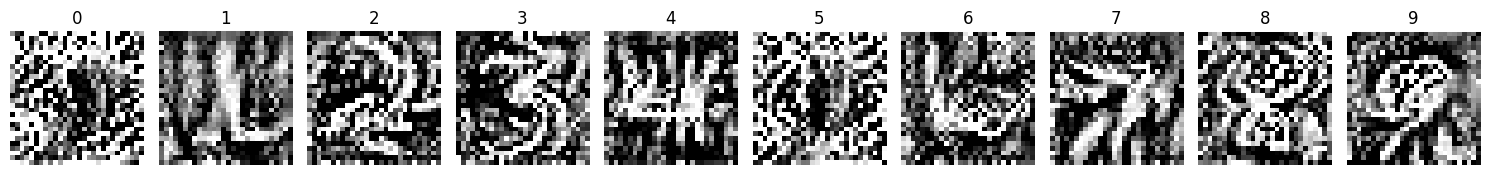

In [12]:
generate_digit_visualizations(mnist_model, device, steps=1000)

## 6. Corrupted MNIST Evaluation

### 6.1 Load and Merge MNIST-C

#### **Preprocessing and Dataset Handling**

We got our dataset from https://zenodo.org/records/3239543.

Before training or evaluation, we applied a consistent set of preprocessing steps:

- Stored as `.npy` arrays containing 30 synthetic distortions, categorized into corruption types.  
- A runtime corruption wrapper was implemented to apply selected augmentations during training.  
- Corruptions were hand-selected and grouped into difficulty tiers: easy, medium, hard, and challenging.  
- Each tier contained distortions like noise, contrast changes, and translation errors.  

While more modern approaches (e.g., RGB conversion) could’ve been explored with additional time, our pipeline was efficient and effective for our constraints.






In [13]:
class CorruptedMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, corruption_pool, use_rgb=False, resize_to=None):
        self.dataset = base_dataset
        self.corruptions = corruption_pool
        self.use_rgb = use_rgb
        self.resize_to = resize_to

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img_pil = TF.to_pil_image(img)

        corrupted = apply_random_corruption(img_pil, corruption_pool=self.corruptions)
        if self.resize_to:
            corrupted = corrupted.resize(self.resize_to)

        if self.use_rgb:
            corrupted = corrupted.convert("RGB")

        img_tensor = TF.to_tensor(corrupted)
        return img_tensor, label


In [14]:
# Batch load all aviable corruptions

def load_corruption_dict(root_dir, to_rgb=False, resize_to=None):
    root_dir = Path(root_dir)
    corruption_dict = {}

    for image_path in sorted(root_dir.glob("*_test_images.npy")):
        corruption = image_path.stem.replace("_test_images", "")
        label_path = root_dir / f"{corruption}_test_labels.npy"

        if not label_path.exists():
            print(f"Skipping {corruption}: labels not found.")
            continue

        corruption_dict[corruption] = MNISTDataset(
            image_path,
            label_path,
            to_rgb=to_rgb,
            resize_to=resize_to
        )

    if not corruption_dict:
        raise ValueError(f"No corruption datasets found in {root_dir}")

    return corruption_dict

In [15]:
MNIST_C_SPLIT_ROOT = "data/mnist-c-split"
MNIST_C_LEFTOVER_ROOT = "data/mnist-c-leftover"

# Loads both the corruptions sets
mnist_c_split_dict = load_corruption_dict("data/mnist-c-split", to_rgb=False)
mnist_c_leftover_dict = load_corruption_dict("data/mnist-c-leftover", to_rgb=False)

# Merge them all together into one dictionary
full_corruption_dict = {**mnist_c_split_dict, **mnist_c_leftover_dict}

# Combines all test corruption datasets into a signle dataset
combined_mnist_c_test = ConcatDataset([
    *mnist_c_split_dict.values(),
    *mnist_c_leftover_dict.values()
])

### 6.2 Visualize MNIST-C Samples

In [16]:
def get_mnistc_examples_by_digit(dataset, digits=range(10)):
    seen = set()
    samples = []
    
    # Shuffle the dataset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    dataset = torch.utils.data.Subset(dataset, indices)

    for x, y in dataset:
        if int(y) in digits and int(y) not in seen:
            seen.add(int(y))
            img = TF.to_pil_image(x)
            samples.append((img, y))
        if len(seen) == len(digits):
            break

    return samples

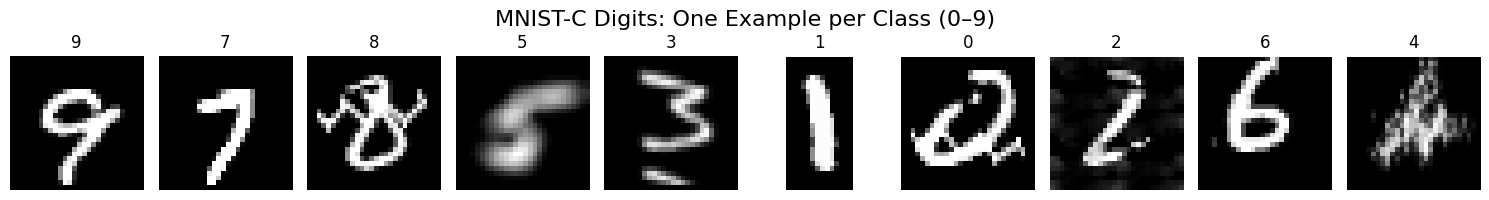

In [17]:
digit_samples = get_mnistc_examples_by_digit(combined_mnist_c_test)

plt.figure(figsize=(15, 2))
for i, (img, label) in enumerate(digit_samples):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")

plt.suptitle("MNIST-C Digits: One Example per Class (0–9)", fontsize=16)
plt.tight_layout()
plt.show()

### 6.3 Evaluate on Corruptions

#### **The Baseline and What It Tells Us**

- When tested on MNIST-C without any corruption-aware training, the same model dropped to ~78-82% accuracy.  
- This revealed a major gap between ideal and real-world performance.  
- The model was only trained on  clean data and failed to generalize to distortions it had never seen.  
- Validated the need for curriculum training and robustness-focused techniques.


#### **What We Analyzed**
- Used pre-training zero-shot tests to identify which corruptions caused the steepest accuracy drop.  
- Contrast, fog, and inverse were found to be the most disruptive.  
- Tracked accuracy per corruption type during curriculum rollout to evaluate robustness gains.  
- Performed confusion matrix analysis to inspect common misclassifications.  
- Evaluated the effectiveness of Mixup, label smoothing, and training length on corrupted performance.


In [18]:
mnist_c_test_loader = DataLoader(combined_mnist_c_test, batch_size=128)

mnist_c_results_df = evaluate_model(
    model=mnist_model,
    test_loader=mnist_c_test_loader,
    device=device,
    show_confusion=False,
    per_digit=False
)


Total Accuracy: 0.7845


In [19]:
corruption_results_df = evaluate_per_corruption(mnist_model, full_corruption_dict, device)

In [20]:
filtered_df = corruption_results_df[
    corruption_results_df["accuracy"] <= 0.95
].drop(columns=["num_samples"])

filtered_df

,corruption,accuracy
0,contrast,0.1135
1,fog,0.1158
2,inverse,0.2333
3,defocus_blur,0.3935
4,gaussian_blur,0.5277
5,frost,0.6117
6,gaussian_noise,0.6205
7,translate,0.6644
8,canny_edges,0.6845
9,impulse_noise,0.7049


## 7. Curriculum Training Utilities

In [21]:
# MIXUP 
# Applies Mixup to a batch of inputs and lables 
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_onehot = F.one_hot(y, num_classes=10).float()
    mixed_y = lam * y_onehot + (1 - lam) * y_onehot[index]
    return mixed_x, mixed_y

# Evaluates model on a single dataset 
def evaluate_model_new(model, datasets, device):
    model.eval()
    if not isinstance(datasets, dict):
        datasets = {"Unnamed": datasets}
    results = {}
    for name, dataset in datasets.items():
        loader = DataLoader(dataset, batch_size=256, shuffle=False)
        correct = total = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                outputs = model(x)
                preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        results[name] = 100.0 * correct / total
    return results if len(results) > 1 else list(results.values())[0]

# Looks up the corruption blen schedule and returns correct ratios
def get_blend_for_epoch(epoch, blend_schedule):
    for (start, end), blend in blend_schedule.items():
        if start <= epoch <= end:
            return blend
    return blend_schedule[max(blend_schedule.keys())]

# Builds a cobined dataset using rations from mutiple corruption groups
def blend_datasets_by_ratio(datasets_dict, ratios, total_samples=60000):
    assert abs(sum(ratios.values()) - 1.0) < 1e-3, "Ratios must sum to 1.0"
    subsets = []
    for key, ratio in ratios.items():
        dataset_list = datasets_dict.get(key, [])
        for dataset in dataset_list:
            n = int(ratio * total_samples // len(dataset_list))
            indices = random.sample(range(len(dataset)), min(n, len(dataset)))
            subsets.append(Subset(dataset, indices))
    return ConcatDataset(subsets) if subsets else None

# Main Curriculum Loop
# Blends dataset based on ration, applies mizup and label smoothing and tracks accurracy across test sets 

def train_with_curriculum(
    model,
    optimizer,
    criterion,
    datasets,
    epoch_blends,
    test_sets,
    num_epochs=20,
    batch_size=64,
    alpha=0.4,
    smoothing=0.1,
    save_path=None,
    scheduler=None,
    show_confusion=False,
    per_digit=False
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    eval_history = defaultdict(list)
    log_history = []  

    for epoch in range(num_epochs):
        model.train()
        blend_ratio = get_blend_for_epoch(epoch, epoch_blends)
        alpha_value = alpha(epoch) if callable(alpha) else alpha
        smoothing_value = smoothing(epoch) if callable(smoothing) else smoothing

        blended_dataset = blend_datasets_by_ratio(datasets, blend_ratio)
        if blended_dataset is None or len(blended_dataset) == 0:
            raise ValueError(f"[Epoch {epoch}] Blended dataset is empty.")

        train_loader = DataLoader(blended_dataset, batch_size=batch_size, shuffle=True)

        total_loss, correct, total = 0.0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            x_mix, y_mix = mixup_data(x, y, alpha=alpha_value)
            y_mix = y_mix * (1 - smoothing_value) + smoothing_value / 10.0

            optimizer.zero_grad()
            outputs = model(x_mix)
            loss = criterion(outputs, y_mix)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        # === Evaluation Phase ===
        eval_results = {}
        for key, dataset in test_sets.items():
            acc = evaluate_model_new(model, dataset, device)
            eval_results[key] = acc
            eval_history[key].append(acc)

        print(f"Epoch {epoch + 1}/{num_epochs} (α={alpha_value:.2f}, ε={smoothing_value:.2f}) | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | " +
              ", ".join(f"{k}: {v:.2f}%" for k, v in eval_results.items()))

        # Save log entry
        log_history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            **{f"test_acc_{k}": v for k, v in eval_results.items()}
        })

        # === Scheduler update based on key metric ===
        if scheduler:
            key = "combined_corruptions" if "combined_corruptions" in eval_results else list(eval_results.keys())[0]
            scheduler.step(eval_results[key])

        # === Optional model checkpoint ===
        if save_path:
            torch.save(model.state_dict(), f"{save_path}_epoch{epoch+1}.pt")

        # === Final epoch: confusion & per-digit report ===
        if epoch == num_epochs - 1:
            if per_digit:
                print("\nPer-Digit Accuracy Report:")
                # pick first test set for report
                for name, ds in test_sets.items():
                    evaluate_model_new(model, ds, device, show_graph=False, verbose=True)
                    break
            if show_confusion:
                for name, ds in test_sets.items():
                    evaluate_model_new(model, ds, device, show_graph=True, verbose=False)
                    break

    return model, eval_history, pd.DataFrame(log_history)

## 8. Designing the Curriculum


### **Why We Selected Our Methods**

We addressed the problem through incremental architectural development and a training strategy focused on robustness rather than raw complexity. Given that MNIST images are 28×28 grayscale images, we choose a lightweight CNN. More advanced networks were impractical given our time and compute constraints.

Before training on corruptions, we used zero-shot evaluation to identify which distortions drastically decreased benchmarks. Contrast, fog, and inverse emerged as distotion impacting benchmarks the most. From this analysis, we created a suite of approximate corruption functions and grouped them into four difficulty tiers.

We began with a 1-layer CNN to establish a minimal baseline. While effective on clean data, it failed on corrupted inputs. We then iteratively expanded the architecture, ultimately finding that a 3-layer CNN provided the best trade-off between complexity and performance. Even when testing deeper networks, performance plateaued around 92–94%, offering no meaningful improvement.

To improve generalization and reduce overfitting, we introduced:

- Mixup to blend inputs and labels for smoother decision boundaries  
- Label smoothing to reduce prediction overconfidence  
- Learning rate scheduling to refine training as progress plateaued


### 8.1 Build and Tier Corruptions

In [22]:
### Utility

# Check if the image is in the correct mode
def ensure_mode(img, mode):
    return img.convert(mode) if img.mode != mode else img

### Basic Image Coruptions

# Adjust Brightness 
def corruption_brightness(img): return ImageEnhance.Brightness(img).enhance(random.uniform(0.7, 1.3))
# Adjust Contrast 
def corruption_contrast(img): return ImageEnhance.Contrast(img).enhance(random.uniform(0.7, 1.3))

# Blends image with Fog Like overlay
def corruption_fog(img):
    overlay = Image.fromarray(np.uint8(np.random.normal(200, 10, img.size[::-1])))
    return Image.blend(ensure_mode(img, "L"), overlay.convert("L"), alpha=0.3)


# Add Gaussian Pixel Noise
def corruption_gaussian_noise(img):
    arr = np.array(img).astype(np.float32)
    noise = np.random.normal(0, 25, arr.shape)
    return Image.fromarray(np.clip(arr + noise, 0, 255).astype(np.uint8))

# Apply Gaussian blur
def corruption_blur(img): return img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.5)))

# Camera motion blur
def corruption_motion_blur(img): return img.filter(ImageFilter.BoxBlur(random.uniform(1, 2)))

# Rotates the image
def corruption_rotate(img): return img.rotate(random.uniform(-30, 30))

# Affline Shear
def corruption_shear(img):
    return img.transform(img.size, Image.AFFINE, (
        1, random.uniform(-0.3, 0.3), 0,
        random.uniform(-0.3, 0.3), 1, 0
    ))

# Apply White Specks
def corruption_spatter(img):
    arr = np.array(img)
    mask = np.random.rand(*arr.shape) < 0.03
    arr[mask] = 255
    return Image.fromarray(arr)

# Elastic Warping 
def corruption_elastic(img): return apply_elastic_transform(img)

# Shifts 
def corruption_translate(img): return apply_translation(img)

# Apply realistic Fog
def corruption_realistic_fog(img): return apply_realistic_fog(img)

# Inverts the pixel values 
def corruption_inverse(img): return ImageOps.invert(ensure_mode(img, "L"))

# Adds horizontal black stripes 
def corruption_stripe(img):
    arr = np.array(img)
    for i in range(0, arr.shape[0], 4):
        arr[i:i+2, :] = 0
    return Image.fromarray(arr)

# Canny Edge
def corruption_canny(img):
    arr = np.array(ensure_mode(img, "L"))
    edges = cv2.Canny(arr, 100, 200)
    return Image.fromarray(edges)

# Extreme contrast
def corruption_contrast_extreme(img):
    factor = random.uniform(2.0, 4.0)
    return ImageEnhance.Contrast(img).enhance(factor)

# Apply low or high contrast
def corruption_contrast_augmented(img):
    factor = random.uniform(0.3, 0.7) if random.random() < 0.5 else random.uniform(2.0, 4.0)
    return ImageEnhance.Contrast(img).enhance(factor)

### Generalized Corruptions

# Zoom In/out
def corruption_zoom(img, scale_range=(0.9, 1.1)):
    img = ensure_mode(img, "L")
    w, h = img.size
    scale = random.uniform(*scale_range)
    new_w, new_h = int(w * scale), int(h * scale)
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)
    result = Image.new(img.mode, (w, h))
    paste_w, paste_h = (w - new_w) // 2, (h - new_h) // 2
    result.paste(img_resized, (paste_w, paste_h))
    return result

# Compression Artifact
def corruption_jpeg(img, quality_range=(10, 50)):
    img = ensure_mode(img, "L")
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=random.randint(*quality_range))
    buffer.seek(0)
    return Image.open(buffer).convert("L")

# Simulates Pixelation
def corruption_pixelate(img, factor_range=(2, 5)):
    img = ensure_mode(img, "L")
    factor = random.randint(*factor_range)
    small = img.resize((img.width // factor, img.height // factor), Image.NEAREST)
    return small.resize(img.size, Image.NEAREST)

# Random Black and White Pixels
def corruption_salt_pepper(img, amount=0.02):
    img = ensure_mode(img, "L")
    arr = np.array(img)
    mask = np.random.rand(*arr.shape)
    arr[mask < amount / 2] = 0
    arr[mask > 1 - amount / 2] = 255
    return Image.fromarray(arr)

# Black Square in random locations 
def corruption_cutout(img, size=8):
    img = ensure_mode(img, "L")
    arr = np.array(img)
    h, w = arr.shape
    y = random.randint(0, h - size)
    x = random.randint(0, w - size)
    arr[y:y+size, x:x+size] = 0
    return Image.fromarray(arr)

### Helper Functions for above for more advanced effects

def apply_elastic_transform(img, alpha=36, sigma=5):
    img = ensure_mode(img, "L")
    arr = np.array(img)
    random_state = np.random.RandomState(None)
    shape = arr.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    distorted = map_coordinates(arr, indices, order=1, mode='reflect').reshape(shape)
    return Image.fromarray(np.clip(distorted, 0, 255).astype(np.uint8))

def apply_translation(img, max_shift=5):
    width, height = img.size
    x_shift = random.randint(-max_shift, max_shift)
    y_shift = random.randint(-max_shift, max_shift)
    translated = Image.new("L", (width, height), 0)
    translated.paste(img, (x_shift, y_shift))
    return translated


def apply_realistic_fog(img, fog_strength=0.3, blur_radius=1.0):
    width, height = img.size
    noise = np.random.rand(height, width) * 255
    fog_layer = cv2.GaussianBlur(noise, (0, 0), sigmaX=8, sigmaY=8)
    fog_layer = np.clip(fog_layer, 0, 255).astype(np.uint8)
    fog_img = Image.fromarray(fog_layer).convert("L")
    img = ensure_mode(img, "L")
    fogged = Image.blend(img, fog_img, alpha=fog_strength)
    return fogged.filter(ImageFilter.GaussianBlur(blur_radius))

# Tiered Corruption Pools Manualy Set
TIERED_CORRUPTION_POOLS = {
    "easy": {
        "identity": lambda x: x,
        "jpeg_compression": corruption_jpeg,
        "quantize": corruption_contrast_augmented,
        "zoom_blur": corruption_zoom,
        "dotted_line": None,
        "saturate": corruption_contrast,
        "shear": corruption_shear,
        "speckle_noise": corruption_gaussian_noise,
        "shot_noise": corruption_gaussian_noise,
        "brightness": corruption_brightness,
        "spatter": corruption_spatter,
    },
    "moderate": {
        "motion_blur": corruption_motion_blur,
        "pixelate": corruption_pixelate,
        "canny_edges": corruption_canny,
        "defocus_blur": corruption_blur,
        "impulse_noise": corruption_salt_pepper,
        "scale": corruption_zoom,
        "frost": corruption_realistic_fog,
        "rotate": corruption_rotate,
        "gaussian_noise": corruption_gaussian_noise,
        "elastic_transform": corruption_elastic,
        "snow": corruption_spatter,
        "translate": corruption_translate,
    },
    "hard": {
        "inverse": corruption_inverse,
        "fog": corruption_fog,
        "glass_blur": corruption_blur,
        "gaussian_blur": corruption_blur,
        "pessimal_noise": corruption_gaussian_noise,
    },
    "challenging": {
        "zigzag": corruption_contrast_extreme,
        "line": corruption_stripe,
        "contrast": corruption_contrast,
        "stripe": corruption_stripe,
    }
}

# Randomly Seleccts and applies one corruption to the image
def apply_random_corruption(img, corruption_pool, mode="L"):
    img = ensure_mode(img, mode)
    valid_corruptions = [(k, v) for k, v in corruption_pool.items() if callable(v)]
    if not valid_corruptions:
        raise ValueError("Corruption pool has no valid corruption functions.")
    _, corruption_fn = random.choice(valid_corruptions)
    return corruption_fn(img)

In [23]:
def assign_balanced_tiers(df):
    df = df.copy().sort_values(by="accuracy", ascending=True).reset_index(drop=True)

    # First 2 = Challenging
    df.loc[:1, "tier"] = "challenging"

    # Next 10 = Hard, next 10 = Moderate, next 10 = Easy
    df.loc[2:11, "tier"] = "hard"
    df.loc[12:21, "tier"] = "moderate"
    df.loc[22:, "tier"] = "easy"

    return df

def get_balanced_corruption_tiers(df):
    tiered = assign_balanced_tiers(df)

    tiers = {
        "challenging": [],
        "hard": [],
        "moderate": [],
        "easy": []
    }

    for _, row in tiered.iterrows():
        tiers[row["tier"]].append(row["corruption"])

    return tiers


### 8.2: Pooling Corruptions Into Tiers

In [24]:

balanced_tiers = get_balanced_corruption_tiers(corruption_results_df)

for tier in ["easy", "moderate", "hard", "challenging"]:
    print(f"{tier.capitalize()}: {', '.join(balanced_tiers[tier])}")

tiered_datasets = {
    "easy": [CorruptedMNISTDataset(train_mnist, TIERED_CORRUPTION_POOLS["easy"])],
    "moderate": [CorruptedMNISTDataset(train_mnist, TIERED_CORRUPTION_POOLS["moderate"])],
    "hard": [CorruptedMNISTDataset(train_mnist, TIERED_CORRUPTION_POOLS["hard"])],
    "challenging": [CorruptedMNISTDataset(train_mnist, TIERED_CORRUPTION_POOLS["challenging"])],
    "mnist": [train_mnist],  # clean samples
}

test_sets = {
    "clean": test_mnist,
    "combined_corruptions": combined_mnist_c_test
}

Easy: pixelate, shot_noise, speckle_noise, saturate, shear, dotted_line, spatter, jpeg_compression, quantize, identity
Moderate: motion_blur, line, elastic_transform, glass_blur, zigzag, snow, pessimal_noise, zoom_blur, rotate, scale
Hard: inverse, defocus_blur, gaussian_blur, frost, gaussian_noise, translate, canny_edges, impulse_noise, brightness, stripe
Challenging: contrast, fog


In [25]:
def get_mnist_examples_by_corruption():
    seen = set()
    samples = []
    
    # Select a random image from the MNIST dataset and apply each corruption to it
    img = train_mnist[random.randint(0, len(train_mnist) - 1)][0]
    for rank in TIERED_CORRUPTION_POOLS:
        valid_corruptions = [(k, v) for k, v in TIERED_CORRUPTION_POOLS[rank].items() if callable(v)]
        for _, corruption in valid_corruptions:
            if corruption == None:
                continue
            img2 = TF.to_pil_image(img)
            img2 = corruption(img2)
            samples.append((img2, _))

    return samples

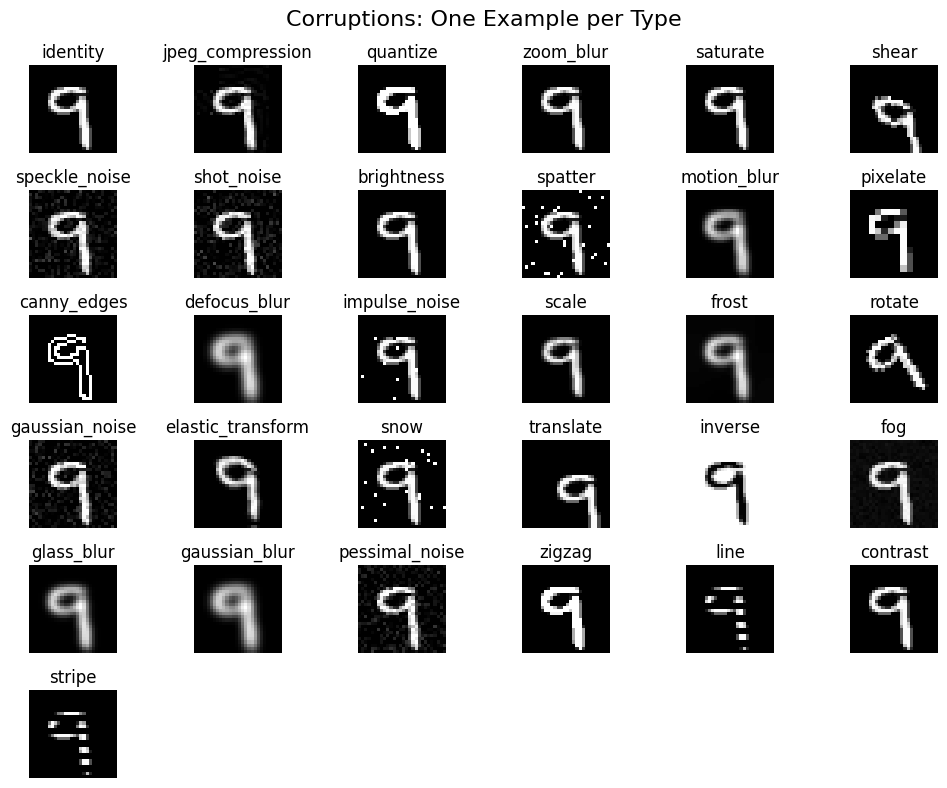

In [26]:
digit_samples = get_mnist_examples_by_corruption()

plt.figure(figsize=(10, 8))
for i, (img, label) in enumerate(digit_samples):
    plt.subplot(6, 6, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")

plt.suptitle("Corruptions: One Example per Type", fontsize=16)
plt.tight_layout()
plt.show()

From the image of the corruptions, some of the labeled corruptions have the same or similar corruption performed on the image compared to others. This is due to some of the corruptions being slight variations of the same corruption, like "gaussian_noise" and "pessimal_noise" are essentially the same thing. We also did this to not have the model know exactly *what* each corruption does to the image, but rather a generalization of that specific corruption.

## 9. Curriculum-Based Training

### **Hyperparameter Tuning and Training Configuration**
We tuned twelve key hyperparameters iteratively. Rather than using grid search, we adjusted based on observed behavior like early saturation or sudden plateaus in accuracy.

Our final setup:
- Architecture: 3-layer CNN, 128 filters, dropout 0.1 → 0.3 across layers
- Optimizer: Adam
- Initial Learning Rate: 0.001
- Scheduler: ReduceLROnPlateau
- Epochs: 15 total (saturation at epoch 6)
- Batch Size: 64
- Loss Function: Cross-entropy with label smoothing (0.1)
- Mixup Ratio: 0.2
- Curriculum: All corruption tiers introduced by epoch 6

We attempted to find the "best" trade-off between convergence speed and robustness to hard corruptions.


### 9.1 Curriculum Training Execution

In [27]:
epoch_blends = {
    # Epochs 0–2: Easy but still moving into robust
    (0, 2): {
        "easy": 0.3,
        "moderate": 0.2,
        "hard": 0.3,
        "challenging": 0.2,
    },
    # Epochs 3–5: Shift diffculty fast
    (3, 5): {
        "easy": 0.1,
        "moderate": 0.2,
        "hard": 0.45,
        "challenging": 0.25,
    },
    # Epochs 6–10: Hard + challenging are the majority
    (6, 10): {
        "easy": 0.0,
        "moderate": 0.1,
        "hard": 0.55,
        "challenging": 0.35,
    },
    # Epochs 11–15: Challenging bootcamp begins
    (11, 15): {
        "easy": 0.0,
        "moderate": 0.0,
        "hard": 0.4,
        "challenging": 0.6,
    }
}

model = SimpleCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

#model = SimpleCNN()  
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
#criterion = nn.CrossEntropyLoss()

model, eval_history, curriculum_df = train_with_curriculum(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    datasets=tiered_datasets,
    epoch_blends=epoch_blends,
    test_sets=test_sets,
    num_epochs=15,
    batch_size=64,
    alpha=0.4,
    smoothing=0.1,
    show_confusion=False,      
    per_digit=False             
)

c:\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 (α=0.40, ε=0.10) | Train Loss: 1.1799 | Train Acc: 0.4891 | clean: 98.43%, combined_corruptions: 93.93%
Epoch 2/15 (α=0.40, ε=0.10) | Train Loss: 1.0614 | Train Acc: 0.5182 | clean: 98.82%, combined_corruptions: 94.95%
Epoch 3/15 (α=0.40, ε=0.10) | Train Loss: 1.0538 | Train Acc: 0.5265 | clean: 98.95%, combined_corruptions: 94.97%
Epoch 4/15 (α=0.40, ε=0.10) | Train Loss: 1.0259 | Train Acc: 0.5367 | clean: 99.04%, combined_corruptions: 95.63%
Epoch 5/15 (α=0.40, ε=0.10) | Train Loss: 1.0032 | Train Acc: 0.5377 | clean: 98.98%, combined_corruptions: 95.95%
Epoch 6/15 (α=0.40, ε=0.10) | Train Loss: 1.0118 | Train Acc: 0.5422 | clean: 99.00%, combined_corruptions: 95.63%
Epoch 7/15 (α=0.40, ε=0.10) | Train Loss: 0.9933 | Train Acc: 0.5477 | clean: 99.05%, combined_corruptions: 96.22%
Epoch 8/15 (α=0.40, ε=0.10) | Train Loss: 0.9971 | Train Acc: 0.5406 | clean: 99.11%, combined_corruptions: 96.25%
Epoch 9/15 (α=0.40, ε=0.10) | Train Loss: 0.9835 | Train Acc: 0.5440 | clean: 99

In [39]:
corruption_results_df = evaluate_per_corruption(
    model=model,
    corruption_dict=full_corruption_dict,
    device=device
)

In [40]:
corruption_results_df = corruption_results_df.drop(columns=["num_samples"])
corruption_results_df

,corruption,accuracy
0,translate,0.7652
1,zigzag,0.9104
2,elastic_transform,0.9205
3,line,0.9229
4,contrast,0.9256
5,canny_edges,0.9317
6,rotate,0.9362
7,gaussian_blur,0.9440
8,pessimal_noise,0.9451
9,stripe,0.9528



It was important that we reached ~99% accuracy on the standard MNIST test set, with a high accuracy on uncorrupted data it confirms that the model has learned the digit classification task, eliminating the concerns of underfitting. Without the original baseline, poor perforamce on corrupted inputs could have been attributed to general model weakness rather than a failure to generalize.

## 10. Visualizing What the Model Sees (Post-Curriculum)

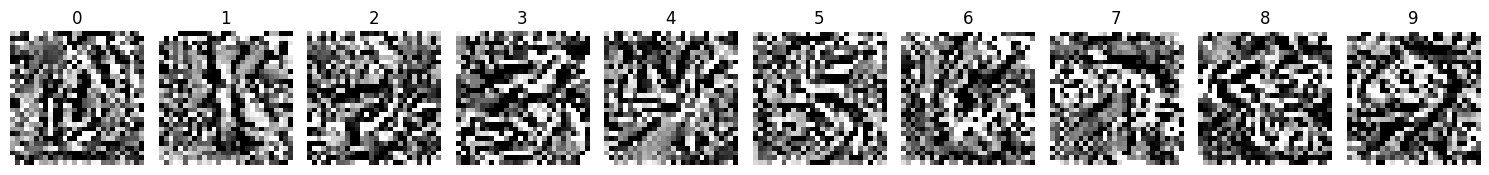

In [41]:
generate_digit_visualizations(model, device, steps=1000)

## 11. Curriculum Evaluation and Comparison

The curriculum-trained model significantly improved robustness on MNIST-C. 

In [50]:
corruption_results_complete_df = corruption_results_df.merge(filtered_df,
                                                             how="inner",
                                                             on="corruption",
                                                             suffixes=("_curriculum", "_original")).sort_values(by="accuracy_original",
                                                                                                                ascending=True)
corruption_results_complete_df.loc[corruption_results_df["corruption"].isin(list(TIERED_CORRUPTION_POOLS["challenging"].keys()))]

,corruption,accuracy_curriculum,accuracy_original
4,contrast,0.9256,0.1135
9,stripe,0.9528,0.8395
3,line,0.9229,0.8759
1,zigzag,0.9104,0.8905


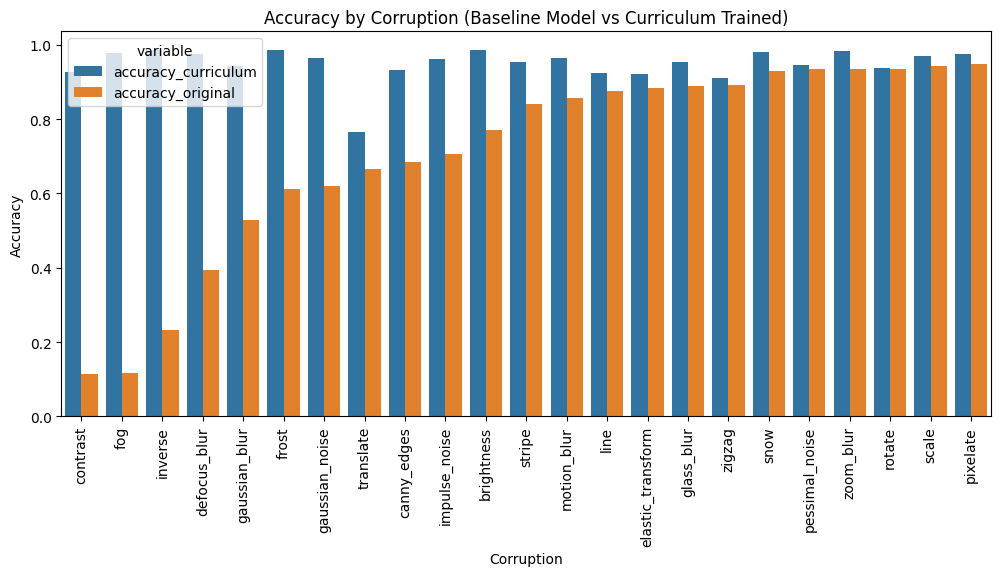

In [43]:
# Display boxplot of accuracy by corruption
corruption_results_complete_wide_df = corruption_results_complete_df.melt(id_vars=["corruption"],
                                                                          value_vars=["accuracy_curriculum", "accuracy_original"])

plt.figure(figsize=(12, 5))
ax = sns.barplot(x="corruption", y="value", hue="variable", data=corruption_results_complete_wide_df)
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Corruption")
ax.set_title("Accuracy by Corruption (Baseline Model vs Curriculum Trained)");

## 12. Domain Generalization: EMNIST Experiments

#### **Preprocessing and Dataset Handling**

Before training or evaluation, we applied a consistent set of preprocessing steps:

- EMNIST images were filtered to include only the digit subset (0–9).  
- Images were normalized and resized to 28×28 grayscale to match MNIST format.  
- Labels were remapped to maintain consistent digit encoding.  
- Used for zero-shot and fine-tuned generalization testing.

### 11.1 Load and Visualize EMNIST Digits

In [44]:
emnist_transform = transforms.Compose([
    transforms.ToTensor()
])

# If this throws an error, run this code block again and it should work
emnist_train = EMNIST(root="data", split="digits", train=True, download=True, transform=emnist_transform)
emnist_test = EMNIST(root="data", split="digits", train=False, download=True, transform=emnist_transform)

In [45]:
def get_emnist_examples_by_digit(dataset, digits=range(10)):
    seen = set()
    samples = []

    for x, y in dataset:
        if int(y) in digits and int(y) not in seen:
            seen.add(int(y))
            img = TF.to_pil_image(x)
            samples.append((img, y))
        if len(seen) == len(digits):
            break

    return samples

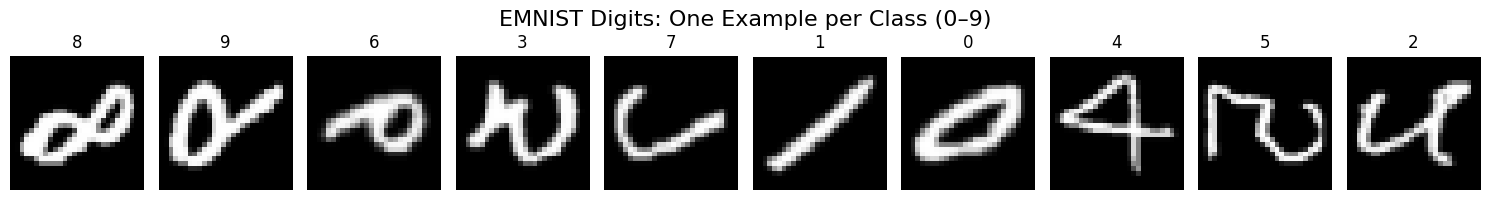

In [46]:
digit_samples = get_emnist_examples_by_digit(emnist_train)

plt.figure(figsize=(15, 2))
for i, (img, label) in enumerate(digit_samples):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{label}")
    plt.axis("off")

plt.suptitle("EMNIST Digits: One Example per Class (0–9)", fontsize=16)
plt.tight_layout()
plt.show()

### 11.2 Fine-Tune Baseline Model

#### **The Baseline and What It Tells Us**
- EMNIST was used for zero-shot domain testing , the model trained only on MNIST and MNIST-C was evaluated without any EMNIST-specific fine-tuning.  
- Accuracy dropped to around 20%, even after filtering EMNIST to only include digits.  

### **What we Analyzed** 

- This highlighted the difference between robustness to noise vs. different handwriting styles. 
- This showed that robustness to corruptions does not equal robustness to new handwriting styles.  
- Reinforced that domain generalization and corruption generalization are different.  
- Performed a brief fine-tuning experiment to see if adaptation to EMNIST was feasible post-training and with a 3 epoch tune it was at 99%

In [47]:
def fine_tune_on_emnist(model, emnist_train, emnist_test, epochs=3, lr=1e-4, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(emnist_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(emnist_test, batch_size=batch_size, shuffle=False)

    print(f"\n Fine-tuning for {epochs} epochs on EMNIST digits...")

    for epoch in range(epochs):
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

    # === Evaluation ===
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            preds = output.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # Per-digit accuracy
    digit_accs = []
    for i in range(10):
        mask = (all_labels == i)
        acc = (all_preds[mask] == i).float().mean().item()
        digit_accs.append(acc)

    df = pd.DataFrame({
        "Digit": list(range(10)) + ["Overall"],
        "Accuracy": digit_accs + [accuracy_score(all_labels, all_preds)]
    })

    print("\n📊 Accuracy after Fine-Tuning:")
    display(df.round(4))

    # Optional: Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix – EMNIST After Fine-Tuning")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return model,df


 Fine-tuning for 3 epochs on EMNIST digits...
Epoch 1/3 - Loss: 0.2890
Epoch 2/3 - Loss: 0.0510
Epoch 3/3 - Loss: 0.0364

📊 Accuracy after Fine-Tuning:


,Digit,Accuracy
0,0,0.9960
1,1,0.9970
2,2,0.9945
3,3,0.9925
4,4,0.9912
5,5,0.9933
6,6,0.9958
7,7,0.9960
8,8,0.9940
9,9,0.9960


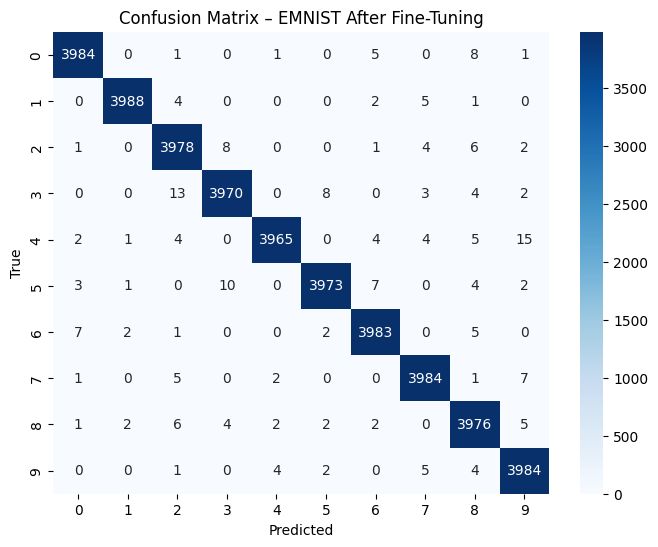

In [49]:
emnist_model, df_emnist = fine_tune_on_emnist(
    model=model,
    emnist_train=emnist_train,
    emnist_test=emnist_test,
    epochs=3,           
    lr=1e-4,
    batch_size=64
)

### **Analysis of What Worked**
Grouping corruptions into tiers and introducing them gradually avoided overwhelming the model and led to faster convergence. Mixup and label smoothing were especially helpful during the later stages of training, when overfitting was more likely.
Although we reached a performance plateau around epoch 6, we extended training to 15 epochs, which allowed the model to adapt to harder corruptions. The result was a more robust model, though still one that needed fine-tuning for domain transfer.
